In [1]:
!git clone https://github.com/huggingface/neuralcoref.git

Cloning into 'neuralcoref'...
remote: Enumerating objects: 772, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 772 (delta 10), reused 5 (delta 1), pack-reused 748
Receiving objects: 100% (772/772), 67.85 MiB | 28.23 MiB/s, done.
Resolving deltas: 100% (407/407), done.


In [2]:
pip install neo4j-driver==1.6.2

     |████████████████████████████████| 191 kB 925 kB/s            
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for neo4j-driver: filename=neo4j_driver-1.6.2-cp37-cp37m-linux_x86_64.whl size=707605 sha256=9b8bee6f5fb20bc2ba452bb019c38a9ec3bc01d6518d44a849b9ab6a758a5190
  Stored in directory: /root/.cache/pip/wheels/fc/37/2c/7080315b0c060e9264c96574e9f50db5d4815e52adc86bb935
  Created wheel for neotime: filename=neotime-1.0.0-py3-none-any.whl size=14712 sha256=393bfab8df7dd197b3fbb849eca7eef1c3d4432c6414821926c16c5c9dcd0c43
  Stored in directory: /root/.cache/pip/wheels/6e/53/79/7045b9d082d0671e91faeebdc5f8bd7d4358a9a7b9df8b302d
Successfully built neo4j-driver neotime
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install allennlp
!pip install allennlp-models
!python -m spacy download en
!python3 -m pip install neo4j --user

  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.1

**Coreference Resolution**

In [4]:
import pandas as pd
import json
import urllib
import nltk
import neuralcoref
import networkx as nx
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from neo4j import GraphDatabase
from allennlp.predictors.predictor import Predictor

In [5]:
text = """Elon Musk is a business magnate, industrial designer, and engineer. 
He is the founder, CEO, CTO, and chief designer of SpaceX. He is also early investor, CEO, and product architect of Tesla, Inc. 
He is also the founder of The Boring Company and the co-founder of Neuralink. A centibillionaire, 
Musk became the richest person in the world in January 2021, with an estimated net worth of $185 billion at the time, surpassing Jeff Bezos. 
Musk was born to a Canadian mother and South African father and raised in Pretoria, South Africa. 
He briefly attended the University of Pretoria before moving to Canada aged 17 to attend Queen's University. 
He transferred to the University of Pennsylvania two years later, where he received dual bachelor's degrees in economics and physics. 
He moved to California in 1995 to attend Stanford University, but decided instead to pursue a business career. 
He went on co-founding a web software company Zip2 with his brother Kimbal Musk."""


In [6]:
model_url = "https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2020.02.27.tar.gz"
predictor = Predictor.from_path(model_url)

def Coreference(text):
    
    prediction = predictor.predict(document=text)  # get prediction

    return (predictor.coref_resolved(text))

downloading:   0%|          | 0.00/1.25G [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/414 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/634M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
text = Coreference(text)
print(text)

Elon Musk is a business magnate, industrial designer, and engineer. 
Elon Musk is the founder, CEO, CTO, and chief designer of SpaceX. Elon Musk is also early investor, CEO, and product architect of Tesla, Inc. 
Elon Musk is also the founder of The Boring Company and the co-founder of Neuralink. A centibillionaire, 
Elon Musk became the richest person in the world in January 2021, with an estimated net worth of $185 billion at the time, surpassing Jeff Bezos. 
Elon Musk was born to a Canadian mother and South African father and raised in Pretoria, South Africa. 
Elon Musk briefly attended the University of Pretoria before moving to Canada aged 17 to attend Queen's University. 
Elon Musk transferred to the University of Pennsylvania two years later, where Elon Musk received dual bachelor's degrees in economics and physics. 
Elon Musk moved to California in 1995 to attend Stanford University, but decided instead to pursue a business career. 
Elon Musk went on co-founding a web software c

**Named Entity Recognition With NLTK**

In [8]:
word = nltk.word_tokenize(text)
pos_tag = nltk.pos_tag(word)
chunk = nltk.ne_chunk(pos_tag)
for ele in chunk:
    if isinstance(ele, nltk.Tree):
        print (ele)


(PERSON Elon/NNP)
(ORGANIZATION Musk/NNP)
(PERSON Elon/NNP Musk/NNP)
(ORGANIZATION CEO/NNP)
(ORGANIZATION CTO/NNP)
(ORGANIZATION SpaceX/NNP)
(PERSON Elon/NNP Musk/NNP)
(ORGANIZATION CEO/NNP)
(GPE Tesla/NNP)
(ORGANIZATION Boring/NNP Company/NNP)
(GPE Neuralink/NNP)
(PERSON Elon/NNP Musk/NNP)
(PERSON Jeff/NNP Bezos/NNP)
(PERSON Elon/NNP Musk/NNP)
(GPE Canadian/JJ)
(GPE South/NNP African/NNP)
(GPE Pretoria/NNP)
(GPE South/NNP Africa/NNP)
(PERSON Elon/NNP Musk/NNP)
(ORGANIZATION University/NNP)
(GPE Pretoria/NNP)
(GPE Canada/NNP)
(PERSON Queen/NNP)
(ORGANIZATION University/NNP)
(PERSON Elon/NNP Musk/NNP)
(ORGANIZATION University/NNP)
(GPE Pennsylvania/NNP)
(PERSON Elon/NNP Musk/NNP)
(PERSON Elon/NNP Musk/NNP)
(GPE California/NNP)
(ORGANIZATION Stanford/NNP University/NNP)
(PERSON Elon/NNP Musk/NNP)
(PERSON Elon/NNP Musk/NNP)
(PERSON Kimbal/NNP Musk/NNP)


**Named Entity Recognition With Spacy**

In [9]:
import spacy
nlp = spacy.load("en_core_web_sm")
txt = nlp(text)
table = []
for ent in txt.ents:
    table.append([ent.text,ent.label_,spacy.explain(ent.label_)])

In [10]:
df = pd.DataFrame(table, columns=['Entity', 'Label','Label_Description']).sort_values(by=['Label'])

In [11]:
df

,Entity,Label,Label_Description
18,17,DATE,Absolute or relative dates or periods
22,two years later,DATE,Absolute or relative dates or periods
8,January 2021,DATE,Absolute or relative dates or periods
26,1995,DATE,Absolute or relative dates or periods
15,South Africa,GPE,"Countries, cities, states"
17,Canada,GPE,"Countries, cities, states"
14,Pretoria,GPE,"Countries, cities, states"
25,California,GPE,"Countries, cities, states"
9,$185 billion,MONEY,"Monetary values, including unit"
12,Canadian,NORP,Nationalities or religious or political groups


In [12]:
!git clone https://github.com/thunlp/OpenNRE.git

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Cloning into 'OpenNRE'...
remote: Enumerating objects: 1518, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 1518 (delta 83), reused 81 (delta 43), pack-reused 1377
Receiving objects: 100% (1518/1518), 266.83 MiB | 28.72 MiB/s, done.
Resolving deltas: 100% (903/903), done.


In [13]:
import os
os.chdir("./OpenNRE")

In [14]:
!ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
LICENSE    benchmark  opennre	requirements.txt  tests
README.md  example    pretrain	setup.py


In [15]:
!python setup.py install 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
running install
/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
/opt/conda/lib/python3.7/site-packages/setuptools/command/easy_install.py:159: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  EasyInstallDeprecationWarning,
running bdist_egg
running egg_info
creating opennre.egg-info
writing opennre.egg-info/PKG-INFO
writing dependency_links to opennre.egg-info/dependency_links.txt
writing top-level names to opennre.egg-i

In [16]:
import opennre

In [17]:
model = opennre.get_model('wiki80_bert_softmax')

--2022-04-15 17:42:15--  https://thunlp.oss-cn-qingdao.aliyuncs.com/opennre/pretrain/nre/wiki80_bert_softmax.pth.tar
Resolving thunlp.oss-cn-qingdao.aliyuncs.com (thunlp.oss-cn-qingdao.aliyuncs.com)... 47.104.38.189
Connecting to thunlp.oss-cn-qingdao.aliyuncs.com (thunlp.oss-cn-qingdao.aliyuncs.com)|47.104.38.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 438266333 (418M) [application/x-tar]
Saving to: ‘/root/.opennre/pretrain/nre/wiki80_bert_softmax.pth.tar’

     0K .......... .......... .......... .......... ..........  0%  121K 58m49s
    50K .......... .......... .......... .......... ..........  0%  245K 43m58s
   100K .......... .......... .......... .......... ..........  0%  228K 39m45s
   150K .......... .......... .......... .......... ..........  0% 62.4M 29m50s
   200K .......... .......... .......... .......... ..........  0% 56.3M 23m53s
   250K .......... .......... .......... .......... ..........  0%  227K 25m8s
   300K .......... .....

In [18]:
ENTITY_TYPES = ["human", "person", "company", "enterprise", "business", "geographic region",
                "human settlement", "geographic entity", "territorial entity type", "organization"]

def wikifier(text, lang="en", threshold=0.8):
    """Function that fetches entity linking results from wikifier.com API"""
    # Prepare the URL.
    data = urllib.parse.urlencode([
        ("text", text), ("lang", lang),
        ("userKey", "tgbdmkpmkluegqfbawcwjywieevmza"),
        ("pageRankSqThreshold", "%g" %
         threshold), ("applyPageRankSqThreshold", "true"),
        ("nTopDfValuesToIgnore", "100"), ("nWordsToIgnoreFromList", "100"),
        ("wikiDataClasses", "true"), ("wikiDataClassIds", "false"),
        ("support", "true"), ("ranges", "false"), ("minLinkFrequency", "2"),
        ("includeCosines", "false"), ("maxMentionEntropy", "3")
    ])
    url = "http://www.wikifier.org/annotate-article"
    # Call the Wikifier and read the response.
    req = urllib.request.Request(url, data=data.encode("utf8"), method="POST")
    with urllib.request.urlopen(req, timeout=60) as f:
        response = f.read()
        response = json.loads(response.decode("utf8"))
    # Output the annotations.
    results = list()
    for annotation in response["annotations"]:
        # Filter out desired entity classes
        if ('wikiDataClasses' in annotation) and (any([el['enLabel'] in ENTITY_TYPES for el in annotation['wikiDataClasses']])):

            # Specify entity label
            if any([el['enLabel'] in ["human", "person"] for el in annotation['wikiDataClasses']]):
                label = 'Person'
            elif any([el['enLabel'] in ["company", "enterprise", "business", "organization"] for el in annotation['wikiDataClasses']]):
                label = 'Organization'
            elif any([el['enLabel'] in ["geographic region", "human settlement", "geographic entity", "territorial entity type"] for el in annotation['wikiDataClasses']]):
                label = 'Location'
            else:
                label = None

            results.append({'title': annotation['title'], 'wikiId': annotation['wikiDataItemId'], 'label': label,
                            'characters': [(el['chFrom'], el['chTo']) for el in annotation['support']]})
    return results

In [19]:
# First get all the entities in the sentence
import itertools
relations_list = []
entities = wikifier(text, threshold=.8)
# Iterate over every permutation pair of entities
for permutation in itertools.permutations(entities, 2):
    for source in permutation[0]['characters']:
        for target in permutation[1]['characters']:
            # Relationship extraction with OpenNRE
            data = model.infer(
                {'text': text, 'h': {'pos': [source[0], source[1] + 1]}, 't': {'pos': [target[0], target[1] + 1]}})
            if data[1] > .8:
                relations_list.append(
                    {'source': permutation[0]['title'], 'target': permutation[1]['title'], 'type': data[0]})

In [20]:
relations_list

[{'source': 'Elon Musk', 'target': 'SpaceX', 'type': 'part of'},
 {'source': 'Elon Musk', 'target': 'SpaceX', 'type': 'part of'},
 {'source': 'Elon Musk', 'target': 'SpaceX', 'type': 'has part'},
 {'source': 'Elon Musk', 'target': 'SpaceX', 'type': 'has part'},
 {'source': 'Elon Musk', 'target': 'SpaceX', 'type': 'has part'},
 {'source': 'Elon Musk', 'target': 'SpaceX', 'type': 'has part'},
 {'source': 'Elon Musk', 'target': 'SpaceX', 'type': 'has part'},
 {'source': 'Elon Musk', 'target': 'SpaceX', 'type': 'has part'},
 {'source': 'Elon Musk', 'target': 'SpaceX', 'type': 'has part'},
 {'source': 'Elon Musk', 'target': 'SpaceX', 'type': 'has part'},
 {'source': 'Elon Musk', 'target': 'SpaceX', 'type': 'has part'},
 {'source': 'Elon Musk', 'target': 'SpaceX', 'type': 'has part'},
 {'source': 'Elon Musk', 'target': 'SpaceX', 'type': 'has part'},
 {'source': 'Elon Musk', 'target': 'SpaceX', 'type': 'has part'},
 {'source': 'Elon Musk', 'target': 'SpaceX', 'type': 'has part'},
 {'source': 

In [21]:
data = pd.DataFrame.from_records(relations_list)

In [22]:
data

,source,target,type
0,Elon Musk,SpaceX,part of
1,Elon Musk,SpaceX,part of
2,Elon Musk,SpaceX,has part
3,Elon Musk,SpaceX,has part
4,Elon Musk,SpaceX,has part
...,...,...,...
324,Kimbal Musk,"Tesla, Inc.",has part
325,Kimbal Musk,"Tesla, Inc.",has part
326,Kimbal Musk,"Tesla, Inc.",has part
327,Kimbal Musk,"Tesla, Inc.",has part


In [23]:
G=nx.from_pandas_edgelist(data, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())


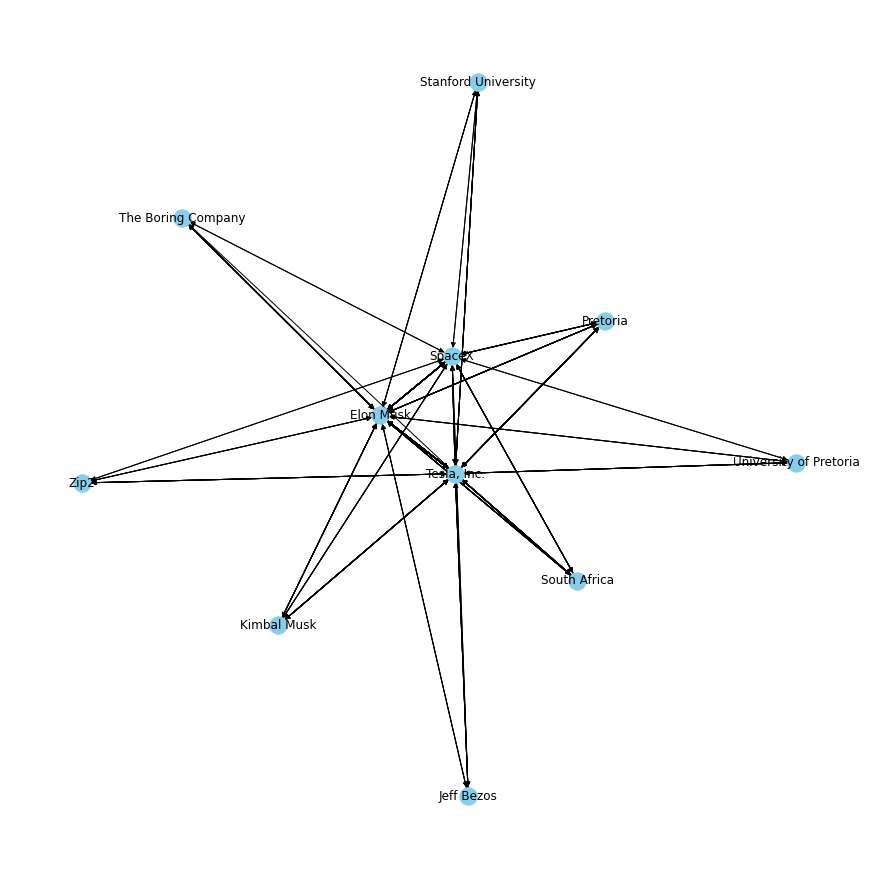

In [24]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()